In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from pyvis.network import Network

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import hdbscan
from umap import UMAP

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv           
from torch_geometric.nn import GINConv
from torch_geometric.nn import SAGEConv

/home/hakan/myEnv/532_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Constants

KEYWORD_SIM_THRESHOLD = 0.4 
AUTHOR_MIN_OVERLAP = 1
DROPOUT = 0.5
LEARNING_RATE = 0.01


In [4]:
# Jaccard similarity helper function

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0
    return len(intersection) / len(union)


In [5]:
# Load JSON data

with open('532_data.json', encoding='utf-8') as f:
    papers = json.load(f)

In [6]:
# Create a graph

G = nx.Graph()

In [7]:
# Add nodes for each paper

for paper in papers:
    paper_id = paper["url"].split("/")[-1]
    G.add_node(
        paper_id,
        title=paper.get("title", ""),
        abstract=paper.get("abstract", ""),
        keywords=paper.get("keywords", []),
        authors=paper.get("authors", []),
        type="paper"
    )

In [8]:
# Example of the first node with all attributes
node_id, node_data = list(G.nodes(data=True))[0]

print("Node id")
print(node_id)
print("\n")

print("Title:")
print(node_data["title"])
print("\n")

print("Keywords:")
for kw in node_data["keywords"]:
    print(kw)
print("\n")

print("Authors:")
for author in node_data["authors"]:
    print(author)
print("\n")

print("Abstract:")
print(node_data["abstract"])

Node id
368013


Title:
The Effect of CuttingTool Wear Behaviors on Feed  Rates in Turning of Metal Matrix Composites


Keywords:
Metal MatrixComposites (MMCs)
Machinability
MgO
Tool wear
Built up edge (BUE)


Authors:
Muharrem Pul
Ulvi Şeker


Abstract:
Composite materials, one of them is metal matrix composites (MMCs), is a group of engineering materials whose application fields expand rapidly. In this study, to make an interpretation on machinability of MMCs materials, MMCs materials reinforced Al matrix and MgO which were produced in 5%, 10% and 15% reinforcement-volumeratios (R-V) were subjected to machining tests by carbide (C) and coated carbide (CC) cutting tools. Machining tests were conducted with 300 m/dak cutting speed, at three different feed rates (0.075, 0.15 and 0.225 mm/dev) and fixed depth of cut (1 mm). After the machining tests, wear characteristics were examined by the help of scanning electron microscope (SEM) views of cuttingtools and the findings were discussed.

In [9]:
# Add edges based on shared keywords or shared authors

nodes = list(G.nodes)
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1 = nodes[i]
        node2 = nodes[j]

        # Shared keywords with Jaccard similarity
        keywords1 = set(G.nodes[node1].get('keywords', []))
        keywords2 = set(G.nodes[node2].get('keywords', []))
        keyword_similarity = jaccard_similarity(keywords1, keywords2)

        if keyword_similarity >= KEYWORD_SIM_THRESHOLD:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

        # Shared authors with count threshold
        authors1 = set(G.nodes[node1].get('authors', []))
        authors2 = set(G.nodes[node2].get('authors', []))
        shared_authors = authors1.intersection(authors2)

        if len(shared_authors) >= AUTHOR_MIN_OVERLAP:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

In [10]:
combined_texts = [
    f"{G.nodes[node]['title']} {G.nodes[node]['abstract']}" for node in G.nodes()
]

embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
umap_model = UMAP(n_neighbors=10, n_components=5, metric="cosine")
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=3)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    verbose=True
)

combined_embeddings = embedding_model.encode(combined_texts, normalize_embeddings=True, show_progress_bar=True)

topics, _ = topic_model.fit_transform(combined_texts, embeddings=combined_embeddings)

Batches: 100%|██████████| 59/59 [00:05<00:00, 10.35it/s]
2025-06-14 03:12:42,426 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-14 03:12:54,567 - BERTopic - Dimensionality - Completed ✓
2025-06-14 03:12:54,570 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-14 03:12:54,642 - BERTopic - Cluster - Completed ✓
2025-06-14 03:12:54,653 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-14 03:12:56,881 - BERTopic - Representation - Completed ✓


In [30]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,442,-1_study_used_using_method,"[study, used, using, method, results, analysis...",[Analysis of Embodied Energy and Carbon Emissi...
1,0,129,0_data_learning_security_images,"[data, learning, security, images, image, base...",[Feature-Based Performance Comparison of Machi...
2,1,112,1_concrete_cement_strength_compressive,"[concrete, cement, strength, compressive, comp...",[Investigation of Lime Use in Cement Paste and...
3,2,65,2_control_motor_controller_motors,"[control, motor, controller, motors, fuzzy, in...",[Direct Torque Control of Asynchronous Motor W...
4,3,61,3_furniture_research_enterprises_production,"[furniture, research, enterprises, production,...",[A Research on the Furniture Foreign Trade in ...
5,4,52,4_fuel_engine_diesel_emissions,"[fuel, engine, diesel, emissions, oil, hydroge...",[A Study on the Performance and Emission Para...
6,5,48,5_stress_element_finite_vibration,"[stress, element, finite, vibration, stresses,...",[Finite Element Analysis and Artificial Neural...
7,6,47,6_power_voltage_converter_transformer,"[power, voltage, converter, transformer, switc...",[DESIGN OF A SINGLE PHASE POWER FACTOR CORRECT...
8,7,45,7_vehicle_design_spring_suspension,"[vehicle, design, spring, suspension, leaf, an...",[Determinaton of the Spring Characteristic of ...
9,8,44,8_welding_welded_weld_hardness,"[welding, welded, weld, hardness, metal, tensi...",[Investigation on the Effect of Projection Typ...


In [31]:
topic_model.get_topic(-1)

[('study', 0.006963574149738681),
 ('used', 0.005539214288759934),
 ('using', 0.005210423513595627),
 ('method', 0.004854559436642175),
 ('results', 0.004301867312095968),
 ('analysis', 0.004243280634313443),
 ('energy', 0.004068103753696228),
 ('process', 0.0037916300067170547),
 ('surface', 0.0037564145103233543),
 ('different', 0.0036795684874384306)]

In [11]:
for i, node in enumerate(list(G.nodes())):
    G.nodes[node]['topic'] = topics[i]

In [12]:
nodes_to_keep = [n for n, attr in G.nodes(data=True) if attr.get('topic', -1) != -1]

filtered_embeddings = []

for n in nodes_to_keep:
    original_idx = list(G.nodes()).index(n)
    filtered_embeddings.append(combined_embeddings[original_idx])

combined_embeddings = filtered_embeddings
nodes_to_remove = [node for node in G.nodes() if G.nodes[node]['topic'] == -1]
G.remove_nodes_from(nodes_to_remove)

In [13]:
def find_similar_papers_by_embedding(query_title, query_abstract, embeddings_np, node_list, top_k=5):

    query_text = f"{query_title} {query_abstract}"
    query_embedding = embedding_model.encode([query_text])[0]
    similarities = cosine_similarity([query_embedding], embeddings_np)[0]
    top_indices = similarities.argsort()[::-1][1:top_k+1]

    print(f"\nTop {top_k} similar papers for: ")
    print(f"Title: {query_title}")
    print(f"Abstract: {query_abstract}")
    print("="*30, "\n")
    for idx in top_indices:
        node_id = node_list[idx]
        data = G.nodes[node_id]

        print(f"Paper ID: {node_id}")
        print(f"Title: {data['title']}")
        print(f"Similarity Score: {similarities[idx]:.4f}")
        print(f"Authors: {', '.join(data.get('authors', []))}")
        print("="*30, "\n")

In [15]:
search_node_id = "1327987"

query_title = G.nodes[search_node_id]['title']
query_abstract = G.nodes[search_node_id]['abstract']

find_similar_papers_by_embedding(query_title, query_abstract, np.array(combined_embeddings), list(G.nodes()), top_k=5)


Top 5 similar papers for: 
Title: Study on Data Center Network Topologies for Monitoring Data using Edge/Fog Computing
Abstract: The election of an appropriate data center network topology is key when dealing with surveillance and monitoring processes, such as those devoted to obtaining relevant data for sensor data fusion in any type of remote computing environment so as to perform fault diagnosis and prevention. In this paper, some of the most commonly used topologies to interconnect nodes within a data center bound to edge/fog computing, representing either switch-centric ones or server-centric ones, are reviewed and analyzed from a statistical point of view in order to measure their performance, resulting in server-centric ones doing it better.

Paper ID: 810896
Title: Arithmetic Study about Energy Save in Switches for some Data Centre Topologies
Similarity Score: 0.6347
Authors: Pedro Juan Roig, Salvador Alcaraz, Katja Gılly, Carlos Juiz

Paper ID: 1327964
Title: Applying Toroida

In [14]:
connected_nodes = [node for node in G.nodes if G.degree(node) > 0]
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]

print(len(connected_nodes))
print(len(isolated_nodes))

957
469


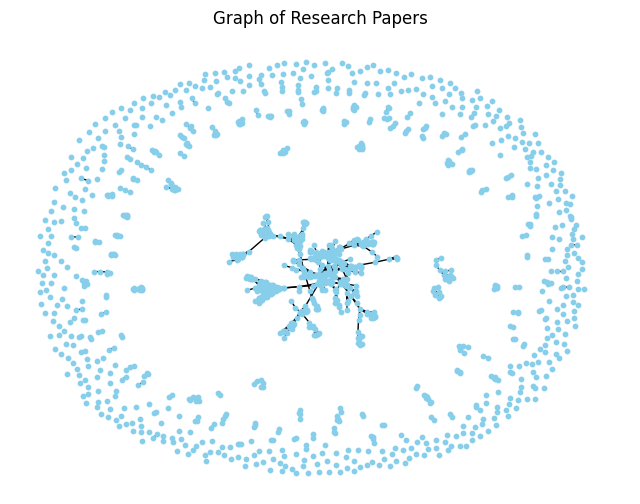

In [15]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=1)

plt.title("Graph of Research Papers")
plt.axis("off")
plt.show()

/tmp/ipykernel_8108/3955444681.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_topics)


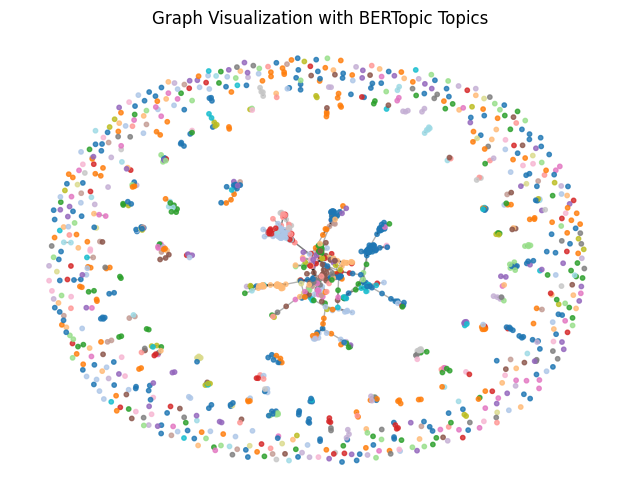

In [16]:
topic_labels = [G.nodes[n].get('topic', -1) for n in G.nodes()]
num_topics = len(set(topic_labels))

cmap = plt.cm.get_cmap('tab20', num_topics)
node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in topic_labels]

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=532)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Graph Visualization with BERTopic Topics")
plt.axis('off')
plt.show()


In [ ]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)

num_topics = len(set(topic_labels))
cmap = plt.cm.get_cmap('tab20', num_topics)
topic_labels = [G.nodes[n].get('topic', -1) for n in G.nodes()]
node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in topic_labels]

for i, node in enumerate(G.nodes()):
    cluster_id = topic_labels[i]
    color = node_colors[i]
    color_hex = '#{:02x}{:02x}{:02x}'.format(
        int(color[0]*255), int(color[1]*255), int(color[2]*255)
    )
    net.add_node(node, label=str(cluster_id), color=color_hex)

for source, target in G.edges():
    net.add_edge(source, target)

net.show("bert_version.html")

/tmp/ipykernel_8108/3555814683.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_topics)


bert_embeddings_version.html


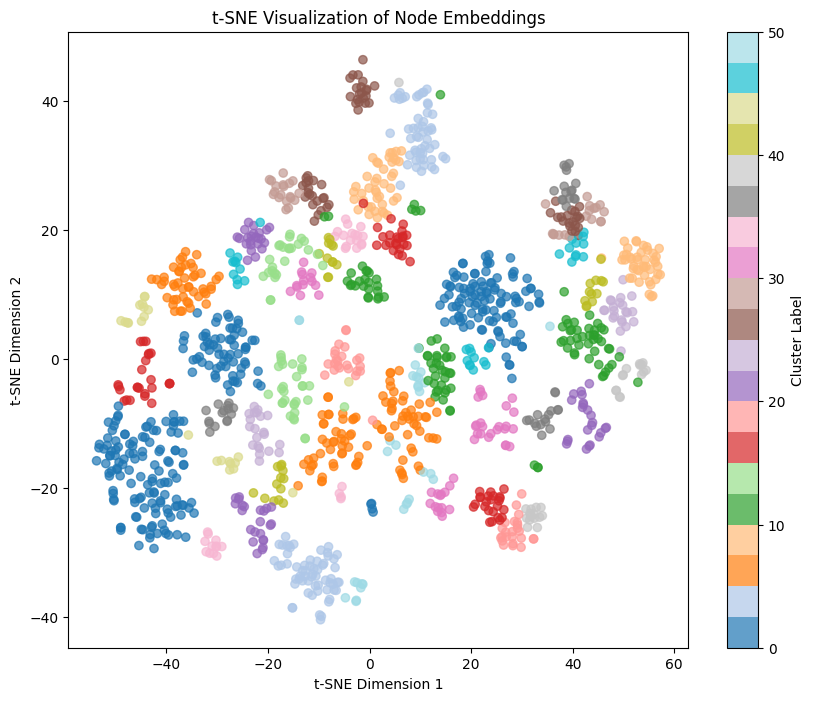

In [18]:
tsne = TSNE(n_components=2, random_state=532)
embeddings_2d = tsne.fit_transform(np.array(combined_embeddings))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=topic_labels, cmap='tab20', alpha=0.7
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [19]:
topics = [topic for topic in topics if topic != -1]

data_x = torch.tensor(combined_embeddings, dtype=torch.float)
data_y = torch.tensor(topics, dtype=torch.long)

data = from_networkx(G)

data.x = data_x
data.y = data_y

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [21]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [22]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [23]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, out_channels))
        self.conv2 = GINConv(nn2)

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [24]:
def train_and_evaluate_gnn(model, data, epochs=100, print_every=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    data = data.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            model.eval()
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            model.train()

    model.eval()
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    true = data.y.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    pred_test = pred[test_mask]
    true_test = true[test_mask]

    precision, recall, f1, _ = precision_recall_fscore_support(true_test, pred_test, average=None)
    print("\nPer-class precision:", [(i, prec) for i, prec in enumerate(precision) if prec != 1])
    print("Per-class recall:", [(i, rec) for i, rec in enumerate(recall) if rec != 1])
    print("Per-class F1-score:", [(i, f) for i, f in enumerate(f1) if f != 1])

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(true_test, pred_test, average='macro')
    print(f"\nMacro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")

    accuracy = accuracy_score(true_test, pred_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

In [25]:
labels = data.y.cpu().numpy()
idx = np.arange(len(labels))

train_idx, test_idx = train_test_split(idx, test_size=0.3, stratify=labels, random_state=532)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=labels[train_idx], random_state=532)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [26]:
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=num_topics, dropout=DROPOUT)

train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 3.9285, Val Loss: 3.8686
Epoch 10, Train Loss: 3.0454, Val Loss: 3.0040
Epoch 20, Train Loss: 2.1247, Val Loss: 2.2151
Epoch 30, Train Loss: 1.5926, Val Loss: 1.6988
Epoch 40, Train Loss: 1.3480, Val Loss: 1.4943
Epoch 50, Train Loss: 1.1568, Val Loss: 1.4142
Epoch 60, Train Loss: 0.9898, Val Loss: 1.3609
Epoch 70, Train Loss: 0.9594, Val Loss: 1.3342
Epoch 80, Train Loss: 0.8664, Val Loss: 1.3098
Epoch 90, Train Loss: 0.8478, Val Loss: 1.3089

Per-class precision: [(0, 0.7755102040816326), (1, 0.8787878787878788), (2, 0.72), (3, 0.8125), (4, 0.6666666666666666), (5, 0.6363636363636364), (6, 0.7692307692307693), (8, 0.8571428571428571), (9, 0.5294117647058824), (10, 0.5294117647058824), (11, 0.7777777777777778), (12, 0.8333333333333334), (13, 0.8888888888888888), (14, 0.7), (15, 0.625), (16, 0.5), (17, 0.5555555555555556), (18, 0.4), (19, 0.5), (21, 0.8), (22, 0.6), (24, 0.8), (25, 0.8), (26, 0.8333333333333334), (27, 0.5), (28, 0.8), (29, 0.0), (30, 0.571428571428

In [27]:
model = GAT(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(topic_labels), dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.2604, Val Loss: 6.9277
Epoch 10, Train Loss: 4.6210, Val Loss: 2.9149
Epoch 20, Train Loss: 4.2451, Val Loss: 2.3149
Epoch 30, Train Loss: 3.7152, Val Loss: 1.9941
Epoch 40, Train Loss: 3.8373, Val Loss: 1.8761
Epoch 50, Train Loss: 3.7343, Val Loss: 1.7384
Epoch 60, Train Loss: 3.7406, Val Loss: 1.6638
Epoch 70, Train Loss: 3.4426, Val Loss: 1.6287
Epoch 80, Train Loss: 3.5639, Val Loss: 1.6124
Epoch 90, Train Loss: 3.4018, Val Loss: 1.5693

Per-class precision: [(0, 0.6964285714285714), (1, 0.875), (2, 0.7222222222222222), (3, 0.5714285714285714), (4, 0.6470588235294118), (5, 0.5909090909090909), (6, 0.6666666666666666), (7, 0.6), (8, 0.75), (9, 0.875), (10, 0.7272727272727273), (11, 0.7777777777777778), (12, 0.6666666666666666), (13, 0.7777777777777778), (14, 0.7), (15, 0.8), (16, 0.4), (17, 0.6), (18, 0.3333333333333333), (20, 0.42857142857142855), (21, 0.6), (22, 0.6), (23, 0.8333333333333334), (24, 0.8), (26, 0.8), (27, 0.0), (28, 0.8), (29, 0.0), (30, 0.4)

In [28]:
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(topic_labels), dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.2467, Val Loss: 7.0797
Epoch 10, Train Loss: 3.4141, Val Loss: 3.3065
Epoch 20, Train Loss: 2.4000, Val Loss: 2.3659
Epoch 30, Train Loss: 1.7759, Val Loss: 1.8027
Epoch 40, Train Loss: 1.3200, Val Loss: 1.5144
Epoch 50, Train Loss: 1.0676, Val Loss: 1.3404
Epoch 60, Train Loss: 0.8493, Val Loss: 1.1587
Epoch 70, Train Loss: 0.6965, Val Loss: 1.0497
Epoch 80, Train Loss: 0.6116, Val Loss: 0.9671
Epoch 90, Train Loss: 0.5648, Val Loss: 0.9034

Per-class precision: [(0, 0.8636363636363636), (1, 0.9166666666666666), (2, 0.7692307692307693), (3, 0.9473684210526315), (4, 0.7647058823529411), (5, 0.6666666666666666), (6, 0.8333333333333334), (7, 0.6666666666666666), (8, 0.9230769230769231), (9, 0.7857142857142857), (10, 0.5263157894736842), (11, 0.9), (12, 0.8333333333333334), (14, 0.8), (15, 0.8571428571428571), (16, 0.75), (17, 0.8), (18, 0.5), (19, 0.625), (21, 0.8), (23, 0.8333333333333334), (24, 0.8571428571428571), (26, 0.8333333333333334), (27, 0.666666666666666

In [29]:
model = GIN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(topic_labels))
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.3970, Val Loss: 6.9045
Epoch 10, Train Loss: 4.2222, Val Loss: 4.2355
Epoch 20, Train Loss: 3.0364, Val Loss: 3.8411
Epoch 30, Train Loss: 2.5898, Val Loss: 3.2531
Epoch 40, Train Loss: 2.2236, Val Loss: 2.9746
Epoch 50, Train Loss: 1.8781, Val Loss: 2.9916
Epoch 60, Train Loss: 1.6191, Val Loss: 3.3008
Epoch 70, Train Loss: 1.5400, Val Loss: 3.5495
Epoch 80, Train Loss: 1.3774, Val Loss: 3.6668
Epoch 90, Train Loss: 1.1398, Val Loss: 3.7744

Per-class precision: [(0, 0.6851851851851852), (1, 0.7777777777777778), (2, 0.5789473684210527), (3, 0.7142857142857143), (4, 0.48148148148148145), (5, 0.5), (6, 0.42857142857142855), (7, 0.6), (8, 0.8571428571428571), (9, 0.375), (10, 0.42857142857142855), (11, 0.8), (12, 0.8181818181818182), (13, 0.6666666666666666), (14, 0.5833333333333334), (16, 0.2857142857142857), (17, 0.5), (18, 0.3333333333333333), (19, 0.3), (20, 0.25), (21, 0.36363636363636365), (22, 0.6666666666666666), (23, 0.4), (24, 0.8), (25, 0.4), (29, 0.5), 